In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable, grad

In [2]:
def sgd(func, x_init, lr=1e-2, n_iter=100):
    x = Variable(x_init, requires_grad=True)
    xy = []
    for i in range(n_iter):
        y = func(x)
        xy.append([x.data[0], x.data[1], y.data[0]])
        dx = grad(y, x)[0]
        x.data -= lr * dx.data
    return numpy.array(xy)


def unroll_sgd(func, x_init, lr=1e-2, n_iter=100, n_unroll=20):
    x = Variable(x_init, requires_grad=True)
    lr = Variable(torch.FloatTensor([lr]), requires_grad=True)
    xy = []
    sum_y = 0
    for i in range(1, n_iter):
        y = func(x)
        sum_y += y
        xy.append([x.data[0], x.data[1], y.data[0]])
        dx = grad(y, x, retain_graph=True, create_graph=True)[0]
        x = x - lr * dx
        if i % n_unroll == 0:
            sum_y /= n_unroll
            d_lr = grad(sum_y, lr, retain_graph=True, create_graph=True)[0]
            lr = lr - 1e-4 * d_lr
            print(lr)
    return numpy.array(xy)


def newton(func, x_init, n_iter=100):
    x = Variable(x_init, requires_grad=True)
    xy = []
    for i in range(n_iter):
        y = func(x)
        xy.append([x.data[0], x.data[1], y.data[0]])
        dx = grad(y, x, create_graph=True)[0]
        ddx0 = grad(dx[0], x, retain_graph=True)[0]
        ddx1 = grad(dx[1], x)[0]
        ddx = torch.stack((ddx0, ddx1))
        iddx = ddx.data.inverse()
        x.data -= iddx.mv(dx.data)
    return numpy.array(xy)
    


def f(x):
    return (x[0] - 1)**2 + 10 * (x[0]**2 - x[1])**2


x_init = torch.FloatTensor([0, 1])
sgd_path = sgd(f, x_init)
x_init = torch.FloatTensor([0, 1])
unroll_sgd_path = unroll_sgd(f, x_init)
x_init = torch.FloatTensor([0, 1])
nt_path = newton(f, x_init)
print("SGD:", sgd_path[-1, -1])
print("unroll SGD:", unroll_sgd_path[-1, -1])
print("Newton:", nt_path[-1, -1])
print("Optimal:", f([1, 1]))

Variable containing:
1.00000e-02 *
  2.3442
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  2.3774
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  2.3897
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  2.3955
[torch.FloatTensor of size 1]

SGD: 0.0922205299139
unroll SGD: 0.0267449021339
Newton: 0.0
Optimal: 0


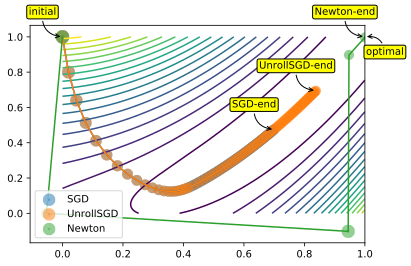

In [3]:
def annotate(ax, point, message, xytext=(-20, 20)):
    ax.annotate(message, xy=point, xytext=xytext, 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1.0),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))    

def plot(f, point_dict):
    N = 500
    x1 = numpy.linspace(0, 1, N)
    x2 = numpy.linspace(0, 1, N)

    X1, X2 = numpy.meshgrid(x1, x2)
    X = numpy.c_[numpy.ravel(X1), numpy.ravel(X2)]
    Y_plot = f([X1, X2])
    Y_plot = Y_plot.reshape(X1.shape)

    fig = plt.figure()
    ax = fig.gca() # projection='3d')
    ax.contour(X1, X2, Y_plot, 20)
    for k, points in point_dict.items():
        ax.plot(points[:, 0], points[:, 1])
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                   label=k, marker="X", linewidths=10, alpha=0.5)
        annotate(ax, points[-1, :2], k + "-end")
    # point optimal point
    annotate(ax, [0, 1], "initial")
    annotate(ax, [1, 1], "optimal", (20, -20))
    ax.legend(loc="lower left")
    plt.savefig("./plot.png")

plot(f, {"SGD": sgd_path, "UnrollSGD": unroll_sgd_path, "Newton": nt_path})